# Emotional Recognition

---
## [Google colab link](https://drive.google.com/file/d/11IwyCcMlImSPerM9IxEDsGMXbsunHCV0/view?usp=sharing)

# Introduction
To predict an emotion through facial expression is a serious problem even for humans. Sometimes the people are not even aware of their own emotions. Тhere is sometimes a big difference between the assessment of the face of a person by different people. However, there may be some models that can be learned from a machine. The purpose of this article is to explore the ability of a machine to guess human emotion from a relatively limited set of face shots. At the end I made a short demo - the machine will try to recognize your emotion.

### Table of content
- [Introduction](#Introduction)
    - [Table of content](#Table-of-content)
    - [About the dataset](#About-the-dataset)
    - [Requirements](#Requirements)

- [Data processing](#Data-processing)

    - [Data analysis](#Data-analysis)
        - [Labels Distribution diagrams](#Labels-Distribution-diagrams)
        - [Knowledge of the images](#Knowledge-of-the-images)
        
    - [Data preparation](#Data-preparation)
        - [How to split the data?](#How-to-split-the-data?)
        - [Data augmentation](#Data-augmentation)
        - [Split the remaining data to training and validation set](#Split-the-remaining-data-to-training-and-validation-set)
    
- [Model selection](#Model-selection)
    - [Preparation](#Preparation)
        - [Reshape and scale the data](#Reshape-and-scale-the-data)
        - [Select an appropriate metric](#Select-an-appropriate-metric)
        - [Define some util functions](#Define-some-util-functions)

    - [Simple Logistic Regression](#Simple-Logistic-Regression)

    - [Dense Neural Network](#Dense-Neural-Network)

    - [Convolutional Neural Networks](#Convolutional-Neural-Networks)

        - [Simple Conv2D Network](#Simple-Conv2D-Network)
    
        - [Select more complicated Conv2D Architecture](#Select-more-complicated-Conv2D-Architecture)
        - [Hyperas Bayesian search](#Hyperas-Bayesian-search)
        - [Conv2D fine hyperparameters tunning](#Conv2D-fine-hyperparameters-tunning)
        - [Run the selected Conv2D model](#Run-the-selected-Conv2D-model)
        - [Test data evaluation](#Test-data-evaluation)
        
    - [Transfer Learning](#Transfer-Learning)
    
        - [VGG16](#VGG16)        
        - [ResNet50](#ResNet50)
        
- [DEMO](#Demo)

### About the dataset

Тhere are large databases like [AffectNet](https://) or [EmotionNet](http://cbcsl.ece.ohio-state.edu/dbform_compound.html) that have millions of labeled color images. However, I decided to use something simpler so I could try different architectures and strategies for a relatively small amount of time.

I chose to use the data from [this Kaggle challenge ](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). Here is some quotes from the original description:

> *""The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).  
> ...  
> The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples. The final test set, which was used to determine the winner of the competition, consists of another 3,589 examples.""*


### Requirements

In [0]:
# used for Bayesian Optimization for Hyperparameter Tuning
!pip install -q hyperas
!pip install -q hyperopt
# color maps for plots
!pip install -q brewer2mpl

In [1]:
from __future__ import print_function

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import brewer2mpl

from itertools import cycle

import pandas as pd
import numpy as np

import itertools

from random import choice
from random import randint
from random import shuffle

import time
import os
import urllib
import tarfile

from enum import Enum

import pickle

import cv2

from scipy import interp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

from tensorflow.python.keras import backend as K

from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50, InceptionResNetV2, InceptionV3

Using TensorFlow backend.


Constants initialization.**You can enable the development mode with `DEV=True` and this will run all cells and calculations**. Typically you won't do this. Keep in mind that the DEMO can be started only on a local machine with camera.

In [2]:
DEV = False
MY_DRIVE = False
INPUT_SHAPE = (48, 48)
INPUT_DIM = INPUT_SHAPE[0]
DOWNLOAD_LINK = "https://www.dropbox.com/s/jf8vblpodlhjayg/emotion_data.tar.gz?dl=1"
DRIVE_PATH = "/content/drive"
PREFIX = os.path.join(DRIVE_PATH, "My Drive/Colab Notebooks")
# PREFIX = "emotion_data"

Downloads some required data:

In [3]:
# Time: ~5 minutes, size ~120Mb
if not MY_DRIVE:
    PREFIX = "emotion_data"
    
    # Downloads the  data
    print("Downloading project data data...")
    response = urllib.request.urlretrieve(DOWNLOAD_LINK)
    tar_url = response[0]
    print("Image data downalod location: '{}'".format(tar_url))
    
    # Time: typically this is extremely fast process but can be very slow on Windows
    # Extracts the downloaded data to './data' directory
    def extract(tar_url, extract_path="."):
        print("Source directory: '{}'".format(tar_url))
        print("Extracting to: '{}'".format(extract_path))
        tar = tarfile.open(tar_url, 'r')
        for item in tar:
            tar.extract(item, extract_path)
            if item.name.find(".tgz") != -1 or item.name.find(".tar.gz") != -1:
                extract(item.name, "./" + item.name[:item.name.rfind('/')])         

    extract(tar_url, ".")
    print('Done.')
    
    # This operation is not mandatory
    # Removes the downlaoded *.tar.gz file from the temporary folder
    try:
        print("Removing '{}' ...".format(tar_url))
        os.remove(tar_url)
    except Exception as ex:
        print(ex)
    print('Done.')
elif MY_DRIVE:
    from google.colab import drive
    drive.mount(DRIVE_PATH)

# Common util functions
def load(file_name):
    obj = pickle.load( open(os.path.join(PREFIX, file_name), "rb" ))
    return obj

def save(obj, file_name):
    pickle.dump(obj, open(os.path.join(PREFIX, file_name), 'wb'))

Image data downalod location: '/tmp/tmprxu0bllf'
Source directory: '/tmp/tmprxu0bllf'
Extracting to: '.'
Done.
Removing '/tmp/tmprxu0bllf' ...
Done.


# Data processing

The data is divided into three subsets: 
- **Training** - 28709
- PublicTest (actually this is **validation set**) - 3589 examples
-  PrivateTest (the **test set**) - 3589 examples


In [4]:
data = pd.read_csv(os.path.join(PREFIX, "fer2013.csv"))
print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
def parse_df(source_df):
    X = [np.fromstring(i, dtype=np.int16, sep=' ') for i in source_df["pixels"]]
    y = source_df.values[:, :1]
    y = y.reshape(-1,)
    y = y.astype("int")
    return X, y

train_df = data[data["Usage"]=="Training"]
val_df = data[data["Usage"]=="PublicTest"]
test_df = data[data["Usage"]=="PrivateTest"]

features_train, targets_train = parse_df(train_df)
features_val, targets_val = parse_df(val_df)
features_test, targets_test = parse_df(test_df)

print(np.asarray(features_train).shape)
print(np.asarray(features_val).shape)
print(np.asanyarray(features_test).shape)
targets_train.reshape(-1,)

(28709, 2304)
(3589, 2304)
(3589, 2304)


array([0, 0, 2, ..., 4, 0, 4])

In [6]:
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
emotion_counts = data["emotion"].value_counts()
usage_counts = data["Usage"].value_counts()
usage_counts

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## Data analysis
I made the following observations:
1. **As you can see the samples from the "Disgust" class are about 500** - that is very low compared to "Happy" class which have almost 9000 samples. I can remove these 500 samples or add the "Disgust" samples to another class.

2. **Some of the images are difficult to classify even by a human being.** That means we will have ** high unavoidable bias**.

3. Although the data is unbalanced, it is evenly distributed among the different sets.

4. The images are small 48x48 (grayscale) and the dataset itself is not particularly large - about 30,000 samples.

### Labels Distribution diagrams

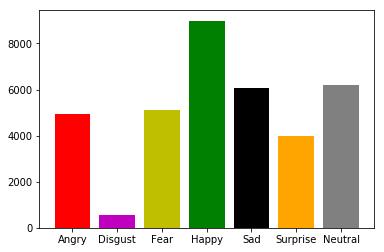

All data:        [4953  547 5121 8989 6077 4002 6198]
Train data:      [3995  436 4097 7215 4830 3171 4965]
Validation data: [467  56 496 895 653 415 607]
Test data:      [491  55 528 879 594 416 626]


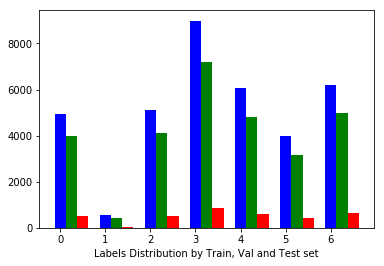

In [7]:
all_data = data.groupby("emotion").size()
train_data = train_df.groupby("emotion").size()
test_data = test_df.groupby("emotion").size()
val_data = val_df.groupby("emotion").size()

def plot_bar(data_df):
    dt = [all_data, train_data, test_data]
    labels = list(range(0, 7))
    em_list = ["Angry","Disgust","Fear", "Happy", "Sad", "Surprise", "Neutral"]
    colors = ["R", "M", "y", "g", "black", "orange", "grey"]
    plt.bar(em_list, height= [dt[0][i] for i in labels], color=colors)
    plt.bar(em_list, height= [dt[1][i] for i in labels], color=colors)
    plt.bar(em_list, height= [dt[2][i] for i in labels], color=colors)
    plt.show()

plot_bar(all_data)
print("All data:       ", all_data.values)
print("Train data:     ", train_data.values)
print("Validation data:", val_data.values)
print("Test data:     ", test_data.values)


dat = [all_data, train_data, test_data]

X = np.arange(7)
plt.bar(X + 0.00, dat[0], color = 'b', width = 0.25)
plt.bar(X + 0.25, dat[1], color = 'g', width = 0.25)
plt.bar(X + 0.50, dat[2], color = 'r', width = 0.25)
plt.xlabel("Labels Distribution by Train, Val and Test set")

plt.show()

### Knowledge of the images

The dataset has a wide variety of images of human faces of different race, age, gender, moods, and luminosity. Some people wear glasses.

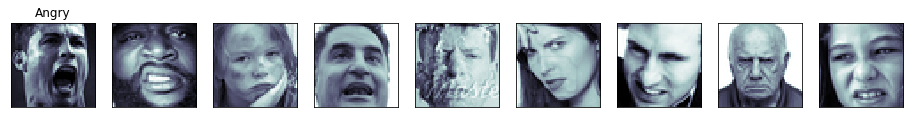

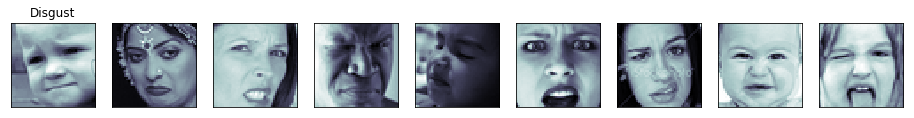

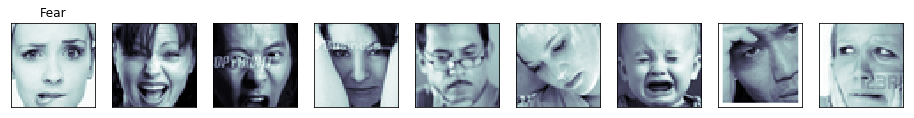

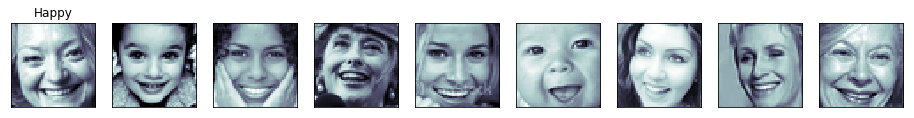

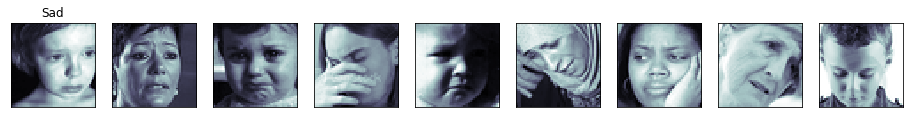

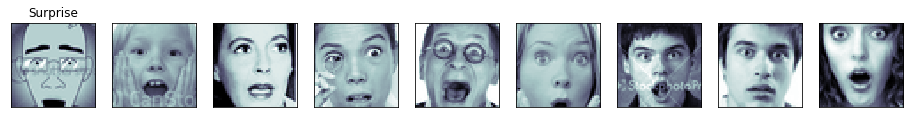

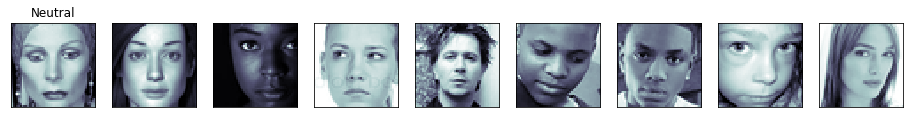

In [10]:
def plot_grid(source, rows, columns, title):
    """ Plots image grid with a certain size """
    fig = plt.figure(figsize=(16, 6))
    for i in range(rows*columns):
        j = randint(0, len(source)-1)
        ax = fig.add_subplot(rows, columns, i + 1, xticks=[], yticks=[])
        plt.imshow(source[j].reshape((INPUT_DIM,INPUT_DIM)), cmap=plt.cm.bone)
        # adds a title for the first image of the row
        if i is 0:
            plt.title(title)
            

def split_labels(dataframe, label):
    X, _ = parse_df(dataframe.loc[dataframe['emotion'] == label])
    return X

# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
X_angry = split_labels(data, label=0)
X_disgust = split_labels(data, label=1)
X_fear = split_labels(data, label=2)
X_happy = split_labels(data, label=3)
X_sad = split_labels(data, label=4)
X_surprise = split_labels(data, label=5)
X_neutral = split_labels(data, label=6)

emotions_map = {"Angry": X_angry, "Disgust": X_disgust, "Fear": X_fear, 
                "Happy": X_happy, "Sad": X_sad, "Surprise": X_surprise, "Neutral": X_neutral}

for title, emotion in emotions_map.items():
    plot_grid(emotion, 1, 9, title)

## Data preparation
**Based on what I saw, I took some rather difficult choices to balance the data and to increase the number of the train/validation examples**:
1. To remove the "Disgust" because the number of the examples is too small
2. To balance the data I will perform data augmentation of the remaining set


### How to split the data?
I decide to split the data in to three sets by using the following strategy:
- **Test set - 5%** of the original data. This is about 1800 images - 300 from each class.
-  **Validation/dev set - 5%** of the aumented/balanced data
- **Training set - 90%** of the augmented/balanced data 


In [11]:
TEST_LABEL_COUNT = 300
def separate_train_data(X_em, count):
    X_em_test = X_em[:count]
    X_em_rest = X_em[count:]
    return X_em_test, X_em_rest

def reconstruct_dataset(X_vec):
    y_vec = [[index]*len(value) for index, value in enumerate(X_vec)]

    X = list(itertools.chain(*X_vec))  # concatenate all Xs
    y = list(itertools.chain(*y_vec))  # conacatenate all ys

    temp_data = list(zip(X, y))
    shuffle(temp_data)
    X, y = zip(*temp_data)

    return X, y


X_angry_test, X_angry_rest = separate_train_data(X_angry, TEST_LABEL_COUNT)
X_fear_test, X_fear_rest = separate_train_data(X_fear, TEST_LABEL_COUNT)
X_happy_test, X_happy_rest = separate_train_data(X_happy, TEST_LABEL_COUNT)
X_sad_test, X_sad_rest = separate_train_data(X_sad, TEST_LABEL_COUNT)
X_surprise_test, X_surprise_rest = separate_train_data(X_surprise, TEST_LABEL_COUNT)
X_neutral_test, X_neutral_rest = separate_train_data(X_neutral, TEST_LABEL_COUNT)

# control prints
print("X_happy size:     ", len(X_happy))
print("X_happy_test size:", len(X_happy_test))
print("X_happy rest size:", len(X_happy_rest))

test_data_list = [X_angry_test, X_fear_test, X_happy_test, X_sad_test, X_surprise_test, X_neutral_test]

X_test, y_test = reconstruct_dataset(test_data_list)

# save the test data
save(X_test, "X_test.pickle")
save(y_test, "y_test.pickle")

# control ptints
print("X_test size:", len(X_test))
print("y_test_size:", len(y_test))
print("Test label distribution:", y_test[:25])

X_happy size:      8989
X_happy_test size: 300
X_happy rest size: 8689
X_test size: 1800
y_test_size: 1800
Test label distribution: (3, 4, 3, 5, 5, 4, 1, 2, 5, 2, 0, 0, 2, 5, 4, 1, 2, 5, 2, 1, 3, 1, 0, 2, 5)


### Data augmentation
The data is not well ballanced, so I'll try **data augmentation** - I will apply some random transformation to the existing data: 
- Horizontal flip
- Scale with a factor in range `[0.8, 1.12]`
- Brightness/contrast
- Rotation with angle between `-20` and `20`

For each selected image I will perform a random transformation with random params.

In [12]:
# Time ~1 min
def scale(image, scales=[0.8, 0.9, 1.1, 1.12]):
    sc = choice(scales)
    rows,cols = image.shape
    M = np.float32([[1,0,0],[0,1,0]])
    res = cv2.resize(image, None, fx=sc, fy=sc,interpolation = cv2.INTER_CUBIC)
    dst = cv2.warpAffine(res,M,(cols,rows))
    return dst


def brightnes_contrast(image, brightnes=30., contrast=1.1):
#     alpha = 1.0 # Simple contrast control
#     beta = 0    # Simple brightness control
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            new_image[y,x] = np.clip(contrast*image[y,x] + brightnes, 0, 255)
    return new_image


def rotate(image, angle=[-20, -15, 15, 20]):
    angle = choice(angle)
    rows,cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(image, M, (cols,rows))
    return dst

def flip(image):
    return np.flip(image, 1)


def augment_data(X, size, transformations):
    aug_size = size - len(X)
    X_augm = list(X)

    for _ in range(aug_size):
        index = randint(0, len(X)-1)
        img = X[index]
        current_transformation = choice(transformations)
        transformed_img = current_transformation(img.reshape(INPUT_SHAPE))
        flatten_img = transformed_img.ravel()
        X_augm.append(flatten_img)
    print("{} -> {}".format(len(X), len(X_augm)))
    return X_augm


# a list with the available transformations
transformations = [flip, scale, rotate, brightnes_contrast]

# perform the data augmentation
UPPER_BOUND = max(data.groupby("emotion").size() - TEST_LABEL_COUNT)
X_angry_aug = augment_data(X_angry_rest, UPPER_BOUND, transformations)
X_fear_aug = augment_data(X_fear_rest, UPPER_BOUND, transformations)
X_happy_aug = augment_data(X_happy_rest, UPPER_BOUND, transformations)
X_sad_aug = augment_data(X_sad_rest, UPPER_BOUND, transformations)
X_surprise_aug = augment_data(X_surprise_rest, UPPER_BOUND, transformations)
X_neutral_aug = augment_data(X_neutral_rest, UPPER_BOUND, transformations)

# a vector with tha augmented data separated by labels
X_vec = [X_angry_aug, X_fear_aug, X_happy_aug, X_sad_aug, X_surprise_aug, X_neutral_aug]

# reconstruncts the data
X_aug, y_aug = reconstruct_dataset(X_vec)

# test prints
print("Test label distribution:", y_aug[:25])
print("X_aug size:", len(X_aug))

# save the augmented data
save(X_aug, "X_aug.pickle")
save(y_aug, "y_aug.pickle")

4653 -> 8689
4821 -> 8689
8689 -> 8689
5777 -> 8689
3702 -> 8689
5898 -> 8689
Test label distribution: (1, 4, 5, 0, 4, 1, 1, 0, 5, 2, 2, 5, 3, 4, 4, 2, 3, 2, 0, 2, 1, 0, 2, 4, 1)
X_aug size: 52134


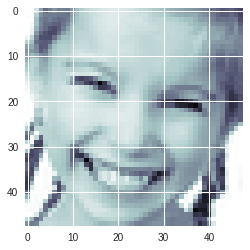

In [0]:
plt.imshow(X_aug[245].reshape(INPUT_SHAPE), cmap=plt.cm.bone)

### Split the remaining data to training and validation set

In [13]:
X_aug = load("X_aug.pickle")
y_aug = load("y_aug.pickle")

X_test = load("X_test.pickle")
y_test = load("y_test.pickle")

X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_aug, y_aug, test_size=0.05, random_state=42)

# test prints
print("X_train_aug size:", len(X_train_aug))
print("X_val_aug size:  ", len(X_val_aug))

X_train_aug size: 49527
X_val_aug size:   2607


# Model selection

## Preparation

### Reshape and scale the data


Before starting the model selection process we need to reshape and scale/normalize the data.
- the range of the pixel values is `[0, 255]`. It can be easily mapped to `[0, 1]` by dividing by`255.0`. In fact this is `MinMaxScaler`.
- each observation is a row vector with size `2304` but because of the Convolutions need to be reshaped to square a matrix with depth 1 - `(48, 48, 1)`

In [37]:
X_train_data = np.array(X_train_aug).reshape(-1, INPUT_DIM, INPUT_DIM, 1)
X_train_data = X_train_data/255.
y_train_data = np.array(y_train_aug)
y_train_data = to_categorical(y_train_data)

X_val_data = np.array(X_val_aug).reshape(-1, INPUT_DIM, INPUT_DIM, 1)
X_val_data = X_val_data/255.
y_val_data = np.array(y_val_aug)
y_val_data = to_categorical(y_val_data)

X_test_data = np.array(X_test).reshape(-1, INPUT_DIM, INPUT_DIM, 1)
X_test_data = X_test_data/255.
y_test_data = np.array(y_test)
y_test_data = to_categorical(y_test_data)


def print_input_data_preview(X, y, data_type):
    print("{} features data: shape: {}, type: {}".format(data_type, X.shape, type(X)))
    print("{} labels data: shape: {}, type: {} ".format(data_type, y.shape, type(y)))

print_input_data_preview(X_train_data, y_train_data, "Train")
print_input_data_preview(X_val_data, y_val_data, "Validation")
print_input_data_preview(X_test_data, y_test_data, "Test")

Train features data: shape: (49527, 48, 48, 1), type: <class 'numpy.ndarray'>
Train labels data: shape: (49527, 6), type: <class 'numpy.ndarray'> 
Validation features data: shape: (2607, 48, 48, 1), type: <class 'numpy.ndarray'>
Validation labels data: shape: (2607, 6), type: <class 'numpy.ndarray'> 
Test features data: shape: (1800, 48, 48, 1), type: <class 'numpy.ndarray'>
Test labels data: shape: (1800, 6), type: <class 'numpy.ndarray'> 


### Select an appropriate metric

-  We have 6 classes so the accuracy of a random classifier or a naive classifier that always predicts the same class should be `~17%`. In means that even a classifier with `50%` accuracy will be much better than the random. 

- Once the base is already balanced I can choose `accuracy` as a metric to measure overall performance. But this is not always in a multiclass classification scenario. This is why for the model selection and assessment it is better to include precision/recall or some measures derived from them like confusion matrix and ROC-curves.

- In this kind of problems the unavoidable bias will be higher than normal. Еven I can not judge to which class some of the emotions belong. In my opinion, in this case the **unavoidable bias**  must be at least 2%.

### Define some util functions

Util functions for plotting learning curves, confusion matrix, roc curves and distribution bars.

In [0]:
def plot_train_vs_validation_acc(history_object):
    f = plt.figure(figsize=(18,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    acc = history_object.history['acc']
    epochs = range(len(acc))
    
    val_acc = history_object.history['val_acc']
    loss = history_object.history['loss']
    val_loss = history_object.history['val_loss']

    ax1.plot(epochs, acc, label='Training acc', color='green')
    ax1.plot(epochs, val_acc, label='Validation acc', color='red')
    ax1.set_title('Training and validation accuracy')
    ax1.legend()

    ax2.plot(epochs, loss, label='Training loss', color="green")
    ax2.plot(epochs, val_loss, label='Validation loss', color="red")
    ax2.set_title('Training and validation loss')
    ax2.legend()


def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues, 
                          classes = ["Angry","Fear", "Happy", "Sad", "Surprise", "Neutral"]):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    title='Confusion matrix'
    
    plt.figure(figsize=(6,6))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 va='center', ha='center', fontsize=16)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_roc_curve(y_test, y_score):
    """ 
    Compute ROC curve and ROC area for each class.
    Compute macro-average ROC curve and ROC area.
    """
    _, n_classes = y_test.shape
    lw = 2 # line weight
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig = plt.figure(figsize=(28,8))
    ax = fig.add_subplot(121)

    # ax.figure()
    ax.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(["R", "M", "y", "g", "black", "orange", "grey"])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Some extension of Receiver operating characteristic to multi-class')
    ax.legend(loc="lower right")
    
    
def plot_distribution_bars(y_true, y_pred, title, color_scheme='Dark2'):
    """
    The function is used to compare the number of true labels as well as prediction results
    """
    labels = ["Angry","Fear", "Happy", "Sad", "Surprise", "Neutral"]
    
    colorset = brewer2mpl.get_map(color_scheme, 'qualitative', 6).mpl_colors
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35   
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(5)

    true = ax.bar(ind, np.bincount(y_true), width, color=colorset, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=colorset, alpha=0.3)
    ax.patch.set_facecolor("white")
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

## Simple Logistic Regression

In [0]:
# # Logistic Regression with sklearn
# lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
# lr.fit(np.asarray(features_train)/255., targets_train)

# f1_score(targets_val, lr.predict(np.asarray(features_val)/255.),average=None)

# lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
# lr.fit(np.asarray(X_train_aug)/255., y_train_aug)

# print( accuracy_score(y_test_aug, lr.predict(np.asarray(X_test_aug)/255.)) )
# print( f1_score(targets_val, lr.predict(np.asarray(features_val)/255.), average=None) )

I will implement a Logistic Regression with its equivalent one layer Neural Network model.

Time: 13.249392076333363 minutes


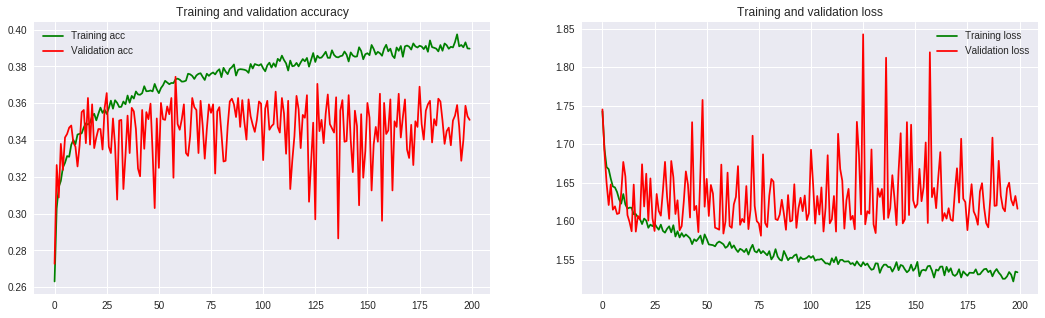

In [0]:
# ~13 minutes
if DEV:
    start_time = time.time()

    lr_model = None

    reg=regularizers.l2(0.01) # origin is 0.01

    lr_model = Sequential()
    lr_model.add(Flatten( input_shape = X_train_data.shape[1:] )) # input_shape = (48, 48, 1)
    lr_model.add(Dense(6))
    lr_model.add(Activation('softmax'))

    lr_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

    lr_history = lr_model.fit(X_train_data, y_train_data, 
                    batch_size=64, 
                    verbose=0,
                    epochs=200,
                    validation_data=(X_val_data, y_val_data))

    plot_train_vs_validation_acc(lr_history)

    stop_time = time.time()
    minutes = (stop_time - start_time)/60.
    print("Time: {} minutes".format(minutes))
    # 13.249392076333363 minutes

From the above charts it becomes clear that we have a problem with **high bias**. I can not even overfit the training data. Regularization, more epochs or adding more data would not be useful. Therefore it is a good idea to try more complex algorithms.

## Dense Neural Network
I will add some hidden layers to the previous network. The input size is 48x48=2304. I will start with 1024 units for the first hidden layer. The аrchitecture will look like this:

$Input(2304) \rightarrow Dense(1024) \rightarrow Dense(512), \rightarrow Dense(128) \rightarrow Dense(6, softmax)$

In [0]:
# ~14 minutes
if DEV:
    start_time = time.time()

    K.clear_session()

    dnn_model = None

    # reg=regularizers.l2(0.01) # origin is 0.01

    dnn_model = Sequential()
    dnn_model.add(Flatten( input_shape = X_train_data.shape[1:] )) # input_shape = (48, 48, 1)

    dnn_model.add(Dense(1024))
    dnn_model.add(Activation('relu'))
    # dnn_model.add(Dropout(0.2))

    dnn_model.add(Dense(512))
    dnn_model.add(Activation('relu'))
    # dnn_model.add(Dropout(0.2))

    dnn_model.add(Dense(128))
    dnn_model.add(Activation('relu'))
    # dnn_model.add(Dropout(0.2))

    dnn_model.add(Dense(6))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    dnn_history = dnn_model.fit(X_train_data, y_train_data, 
                    batch_size=64, 
                    verbose=0,
                    epochs=100,
                    validation_data=(X_val_data, y_val_data))

    stop_time = time.time()
    minutes = (stop_time - start_time)/60.
    print("Time: {} minutes".format(minutes)) # 14.40640244881312 minutes

49527/49527 [==============================] - 4s 83us/step
Avg training accuracy: 0.7850061582535018
2607/2607 [==============================] - 0s 86us/step
Avg validation accuracy: 0.421173763105958


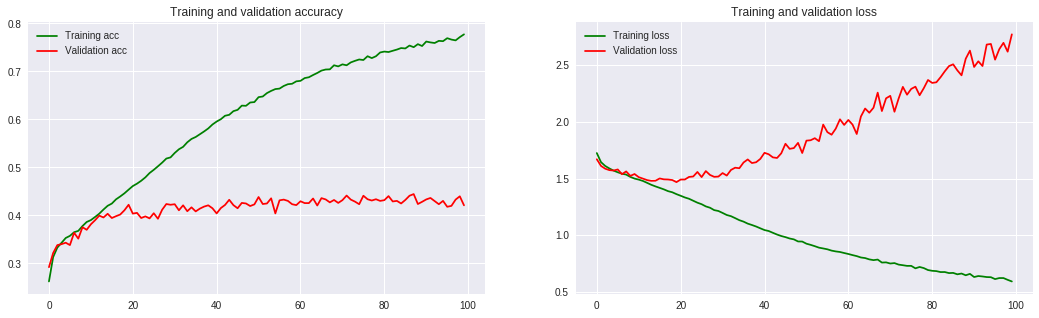

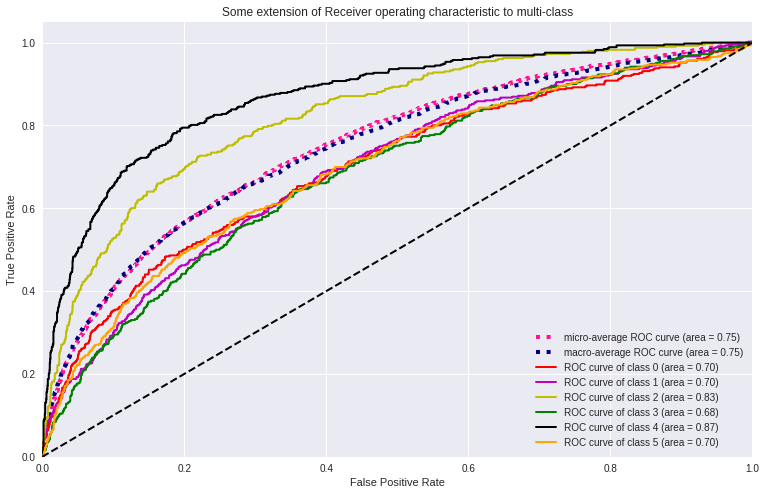

In [0]:
if DEV:
    print("Avg training accuracy: {}".format(dnn_model.evaluate(X_train_data, y_train_data)[1]))
    print("Avg validation accuracy: {}".format(dnn_model.evaluate(X_val_data, y_val_data)[1]))

    y_score = dnn_model.predict(X_val_data, batch_size=64)


    # plots train/validation learning curve
    plot_train_vs_validation_acc(dnn_history)

    # plots a roc curve for each class
    plot_roc_curve(y_test=y_val_data, y_score=y_score)  

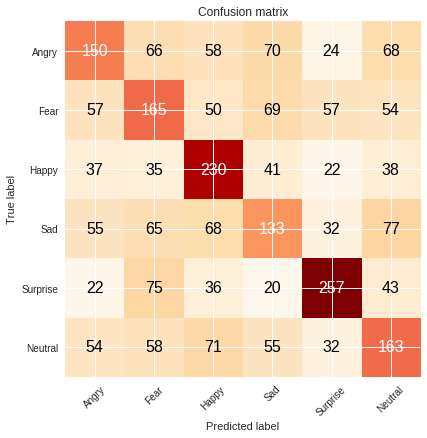

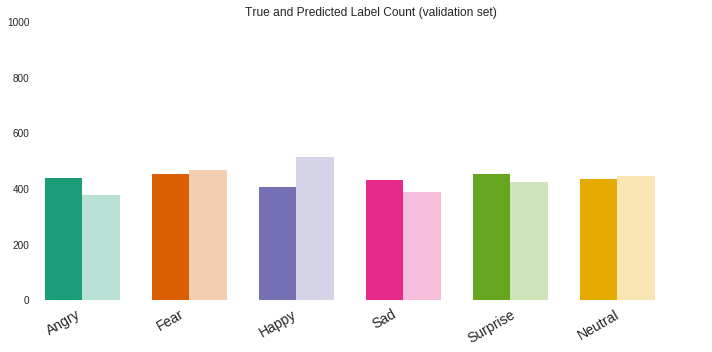

In [0]:
if DEV:
    y_pred =  dnn_model.predict(X_val_data)
    y_pred = [np.argmax(row) for row in y_pred]
    y_true = [np.argmax(row) for row in y_val_data]

    # plots a confusion matrix
    plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.OrRd)


    plot_distribution_bars(y_true, y_pred, 'True and Predicted Label Count (validation set)')

## Convolutional Neural Networks

### Simple Conv2D Network
I will start with a baseline convolutional model with one convolutional layer.

In [0]:
# ~4 minutes
if DEV:
    start_time = time.time()

    K.clear_session()

    s_conv2d_model = Sequential()

    s_conv2d_model.add(Conv2D(64, (3, 3), input_shape=X_train_data.shape[1:] )) # kernel_regularizer=reg
    s_conv2d_model.add(Activation('relu'))
    s_conv2d_model.add(BatchNormalization())
    s_conv2d_model.add(MaxPooling2D(pool_size=(2, 2)))

    # converts the feature maps to 1D feature vectors
    s_conv2d_model.add(Flatten())  

    s_conv2d_model.add(Dense(6))
    s_conv2d_model.add(Activation('softmax'))

    s_conv2d_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])


    s_conv2d_model_history = s_conv2d_model.fit(
                    X_train_data, y_train_data, 
                    batch_size=64, 
                    epochs=20,
                    validation_data=(X_val_data, y_val_data))


    stop_time = time.time()
    minutes = (stop_time - start_time)/60.
    print("Time: {} minutes".format(minutes)) # Time: 4.154778063297272 minutes

49527/49527 [==============================] - 7s 140us/step
Avg validation accuracy: 0.8635087931702778
2607/2607 [==============================] - 0s 139us/step
Avg validation accuracy: 0.4790947449575405


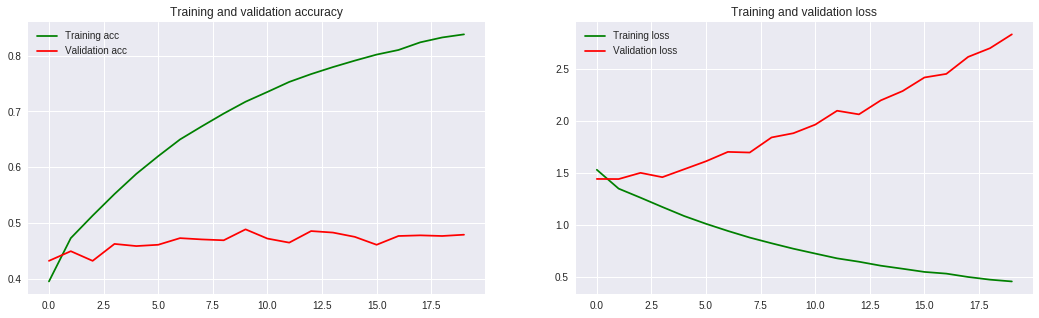

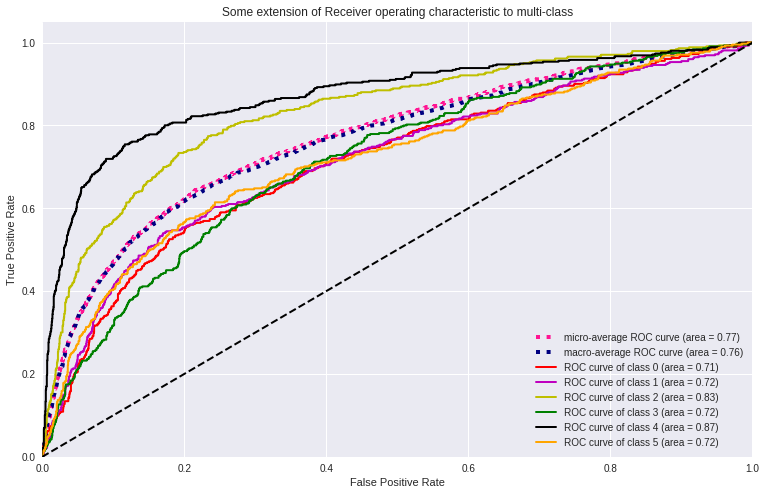

In [42]:
if True:
    print("Avg validation accuracy: {}".format(s_conv2d_model.evaluate(X_train_data, y_train_data)[1]))
    print("Avg validation accuracy: {}".format(s_conv2d_model.evaluate(X_val_data, y_val_data)[1]))

    y_score = s_conv2d_model.predict(X_val_data, batch_size=64)

    # plots train/validation learning curve
    plot_train_vs_validation_acc(s_conv2d_model_history)

    # plots a roc curve for each class
    plot_roc_curve(y_test=y_val_data, y_score=y_score)  

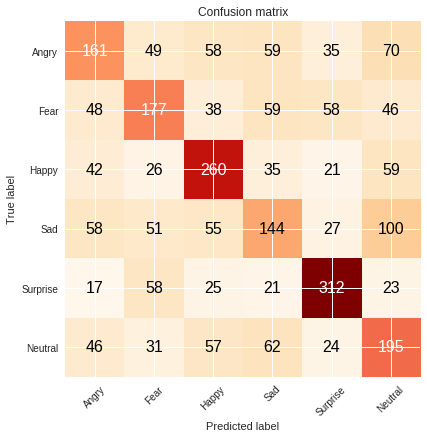

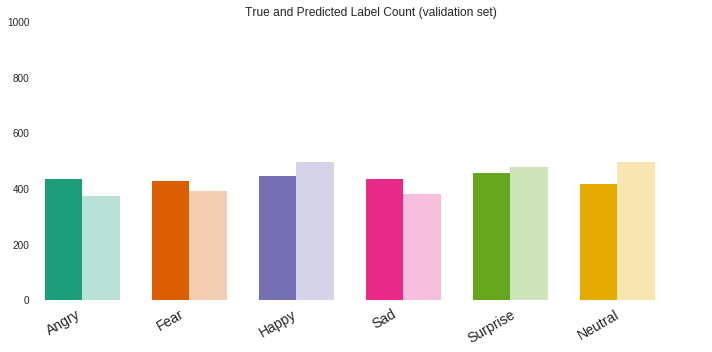

In [43]:
if True:
    y_pred =  s_conv2d_model.predict(X_val_data)
    y_pred = [np.argmax(row) for row in y_pred]
    y_true = [np.argmax(row) for row in y_val_data]

    # plots a confusion matrix
    plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.OrRd)


    plot_distribution_bars(y_true, y_pred, 'True and Predicted Label Count (validation set)')

It's clear from the above charts that the training accuracy trends to overfit while the validation seems to have reached a plateau. This may mean that **some examples with very bad predictions keep getting worse and/or  some examples with very good predictions get a little worse(or a little better)**. As you can see the "Surprise" and "Fear" classes are predicted almost perfectly while some of the other classes do not look so good at all. Maybe I need more complex architecture that can handle more complex features from the minor classes. Of course, this will most likely cause even more problems with overfitting, but on the other hand it would improve the validation result.

### Select more complicated Conv2D Architecture
Аssuming we use standard parameters:
    `learning rate(0.001)`, `Dropout(0, 0.3)`, `BatchNormalization` , `batch_size = 64`, `filter_size=(3, 3)`, `pool_size=(2, 2)` etc. 
    
I think in equal conditions, the choice of the **CNN architecture type** and the **number of the layers** is more important than the other hyperparameters. This is like *meta-hyperparameters tunning*. To choose the most effective architecture I'll use **Hyperas Bayesian search optimization**. Later I'll tune the other params. I desided to use** VGG-like** architecture for the layers  and to optimize the following hyperparams:

1. Nuber of Convolutional layers and the number of the filters:
    - $Conv(32) \rightarrow Pool \rightarrow Conv(64) \rightarrow Pool \rightarrow Conv(128) \rightarrow Pool$

    - $Conv(32) \rightarrow Pool \rightarrow Conv(64) \rightarrow Pool  \rightarrow Conv(128) \rightarrow Pool  \rightarrow Conv(256) \rightarrow Pool$

    - $Conv(32) \rightarrow Conv(64) \rightarrow Conv(64) \rightarrow Pool  \rightarrow Conv(128)-Pool \rightarrow Conv(128)-Pool \rightarrow Conv(256) \rightarrow Pool$
    
    - $Conv(64) \rightarrow Pool \rightarrow Conv(128) \rightarrow Pool \rightarrow Conv(256) \rightarrow Pool$

    - $Conv(64) \rightarrow Pool \rightarrow Conv(128) \rightarrow Pool  \rightarrow Conv(256) \rightarrow Pool  \rightarrow Conv(512) \rightarrow Pool$

    - $Conv(64) \rightarrow Conv(128) \rightarrow Conv(128) \rightarrow Pool  \rightarrow Conv(256)-Pool \rightarrow Conv(256)-Pool \rightarrow Conv(512) \rightarrow Pool$
    
2. Number of Dense layers:
    - $Dense(256), Dropout$
    - $Dense(256), Dropout \rightarrow Dense(128), Dropout$
    
The basic principle followed in building a convolutional neural network is to ‘**keep the feature space wide and shallow in the initial stages of the network, and to make it narrower and deeper towards the end**.’

### Hyperas Bayesian search

In [0]:
# Hyperas is very fastidious library ...
# clears the Python cache
!find . | grep -E "(__pycache__|\.pyc|\.pyo$)" | xargs rm -rf

In [0]:
# Time ~ 111.18751567999522 minutes
if DEV:
    # Please take a shower or do something useful - This is a very slow operation - 1:30  hours...
    start_time = time.time()

    K.clear_session()

    def data():
        x_aug = pickle.load( open(os.path.join(PREFIX, "X_aug_orig.pickle"), "rb" ) )
        y_aug = pickle.load( open(os.path.join(PREFIX, "y_aug_orig.pickle"), "rb" ) )

        x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_aug, y_aug, test_size=0.05, random_state=42)

        x_train_data = np.array(x_train_aug).reshape(-1, INPUT_DIM, INPUT_DIM, 1)
        x_train_data = x_train_data/255.
        y_train_data = np.array(y_train_aug)
        y_train_data = to_categorical(y_train_data)

        x_val_data = np.array(x_val_aug).reshape(-1, INPUT_DIM, INPUT_DIM, 1)
        x_val_data = x_val_data/255.
        y_val_data = np.array(y_val_aug)
        y_val_data = to_categorical(y_val_data)

        return x_train_data, y_train_data, x_val_data, y_val_data


    def create_conv2D_model(x_train_data, y_train_data, x_val_data, y_val_data):
        '''
        Model providing function:
        Create Keras model with double curly brackets dropped-in as needed.
        Return value has to be a valid python dictionary with two customary keys:
         - loss: Specify a numeric evaluation metric to be minimized
         - status: Just use STATUS_OK and see hyperopt documentation if not feasible
        The last one is optional, though recommended, namely:
         - model: specify the model just created so that we can later use it again.
        '''
        m = Sequential()

        def create_layer(filters, input_x_shape=None, padding_type='valid'):
            """ An inner heler function for creating layer """
            if input_x_shape:
                m.add(Conv2D(filters, (3, 3), input_shape=input_x_shape, padding=padding_type))
            else:
                m.add(Conv2D(filters, (3, 3), padding=padding_type ))
            m.add(Activation('relu'))
            m.add(BatchNormalization())


        # the number of the convolutional layers
        model_choice = {{ choice(['two', 'three', 'four']) }}
        # the number of the dense layers
        dense_choice = {{ choice(['none', 'one', 'two']) }}
        # the number of the filters of the first layer
        filters_choice = {{ choice([32, 64])}}
        # whether to double the layers
        double_choice = {{ choice(['yes', 'no']) }}

        filters = 32
        if filters_choice == 64:
            filters = 64

        # the first convolutional layer
        create_layer(filters, input_x_shape=x_train_data.shape[1:], padding_type='valid')

    #     m.add(MaxPooling2D(pool_size=(2, 2)))

        ############### Convolutional layers ###############
        if model_choice == 'two' or model_choice == 'three' or model_choice == 'four':
            # the second convolutional layer
            filters *= 2
            create_layer(filters, padding_type='valid')

            if double_choice == 'yes':
                create_layer(filters, padding_type='same')

            m.add(MaxPooling2D(pool_size=(2, 2)))

        if model_choice == 'three' or model_choice == 'four':
            # third convolutional layer
            filters *= 2
            create_layer(filters, padding_type='valid')

            if double_choice == 'yes':
                create_layer(filters, padding_type='same')

            m.add(MaxPooling2D(pool_size=(2, 2)))

        if model_choice == 'four':
            filters *= 2
            # fourth convolutional layer
            create_layer(filters, padding_type='valid')

            m.add(MaxPooling2D(pool_size=(2, 2)))

        # create a vector
        m.add(Flatten())

        ############### Dense layers ###############
        if dense_choice != 'none':
            if dense_choice == 'one' or dense_choice == 'two':
                # the first dense layer
                m.add(Dense({{choice([512,128])}}, activation='relu'))
                m.add(BatchNormalization())
                m.add(Dropout({{uniform(0, 0.3)}}))

            if dense_choice == 'two':
                # the second dense layer
                m.add(Dense({{choice([512,128])}}, activation='relu'))
                m.add(BatchNormalization())
                m.add(Dropout({{uniform(0, 0.3)}}))

        m.add(Dense(6))
        m.add(Activation('softmax'))

        m.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=0.001), 
                      metrics=['accuracy'])

        m.fit(x_train_data, y_train_data,
                  batch_size=64,
                  epochs=5,
                  verbose=2,
                  validation_data=(x_val_data, y_val_data))

        score, acc = m.evaluate(x_val_data, y_val_data, verbose=0)
        print('Val accuracy:', acc)

        return {'loss': -acc, 'status': STATUS_OK, 'model': m}


    best_run, best_model = optim.minimize(model=create_conv2D_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=15,
                                          notebook_name='drive/My Drive/Colab Notebooks/Face_emotion',
                                          trials=Trials() )

    stop_time = time.time()
    minutes = (stop_time - start_time)/60.
    print("Time: {} minutes".format(minutes))
    # 111.18751567999522 minutes

Here is the result from the hyperparameters search:
```
{'Dense': 1,
 'Dense_1': 0,
 'Dropout': 0.21906917611769802,
 'Dropout_1': 0.0776957747489967,
 'dense_choice': 1,
 'double_choice': 1,
 'filters_choice': 1,
 'model_choice': 2}
 ```
 
 Based on this result I choose the following architecture:
 
$Conv(64) \rightarrow Pool \rightarrow Conv(128) \rightarrow Pool  \rightarrow Conv(256) \rightarrow Pool  \rightarrow Conv(512) \rightarrow Pool$
 

In [0]:
if DEV:
    best_model.save(PREFIX + '/best_hyperas_model.h5')
    # loaded_best_model = load_model(PREFIX + '/best_hyperas_model.h5')

### Conv2D fine hyperparameters tunning
On the basis of the parameters found, we can construct a model that we can fine-tune. Among the other important hyperparams are the **learning rate** and the **batch size**.

In [0]:
# ~ 110 minutes
if DEV:
    start_time = time.time()

    def data():
        DRIVE_PATH = "/content/drive"
        PREFIX = os.path.join(DRIVE_PATH, "My Drive/Colab Notebooks")
        x_aug = pickle.load( open(os.path.join(PREFIX, "X_aug_orig.pickle"), "rb" ) )
        y_aug = pickle.load( open(os.path.join(PREFIX, "y_aug_orig.pickle"), "rb" ) )

        x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_aug, y_aug, test_size=0.05, random_state=42)

        x_train_data = np.array(x_train_aug).reshape(-1, 48, 48, 1)
        x_train_data = x_train_data/255.
        y_train_data = np.array(y_train_aug)
        y_train_data = to_categorical(y_train_data)

        x_val_data = np.array(x_val_aug).reshape(-1, 48, 48, 1)
        x_val_data = x_val_data/255.
        y_val_data = np.array(y_val_aug)
        y_val_data = to_categorical(y_val_data)

        return x_train_data, y_train_data, x_val_data, y_val_data

    # x_train_data, y_train_data, x_val_data, y_val_data = data()

    # K.clear_session()


    def create_better_conv2D_model(x_train_data, y_train_data, x_val_data, y_val_data):
        m = Sequential()

        m.add(Conv2D(64, (3, 3), input_shape=x_train_data.shape[1:] )) # kernel_regularizer=reg
        m.add(Activation('relu'))
        m.add(BatchNormalization())
        # m.add(MaxPooling2D(pool_size=(2, 2)))

        m.add(Conv2D(128, (3, 3) )) # kernel_regularizer=reg
        m.add(Activation('relu'))
        m.add(BatchNormalization())
        m.add(MaxPooling2D(pool_size=(2, 2)))

        m.add(Conv2D(256, (3, 3) )) # kernel_regularizer=reg
        m.add(Activation('relu'))
        m.add(BatchNormalization())
        m.add(MaxPooling2D(pool_size=(2, 2)))

        m.add(Conv2D(512, (3, 3))) # kernel_regularizer=reg
        m.add(Activation('relu'))
        m.add(BatchNormalization())
        m.add(MaxPooling2D(pool_size=(2, 2)))

        # m.add(Conv2D(1024, (3, 3))) # kernel_regularizer=reg
        # m.add(Activation('relu'))
        # m.add(BatchNormalization())
        # m.add(MaxPooling2D(pool_size=(2, 2)))

        m.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

        # m.add(Dense(512))
        # m.add(Activation('relu'))
        # m.add(Dropout(0.0776957747489967))

        m.add(Dense(128))
        m.add(Activation('relu'))
        m.add(BatchNormalization())
        m.add(Dropout(0.1))

        m.add(Dense(6))
        m.add(Activation('softmax'))

        m.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.Adam(lr={{uniform(0.0001, 0.01)}}), #  
                          metrics=['accuracy'])

        m.fit(x_train_data, y_train_data,
                      batch_size={{choice([32, 64, 128])}}, # 
                      epochs=5,
                      verbose=1,
                      validation_data=(x_val_data, y_val_data))

        score, acc = m.evaluate(x_val_data, y_val_data, verbose=0)
        print('Val accuracy:', acc)

        return {'loss': -acc, 'status': STATUS_OK, 'model': m}


    best_run, best_model = optim.minimize(model=create_better_conv2D_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=15,
                                          notebook_name='drive/My Drive/Colab Notebooks/Face_emotion',
                                          trials=Trials() )


    stop_time = time.time()
    minutes = (stop_time - start_time)/60.
    print("Time: {} minutes".format(minutes))

    best_model.save(PREFIX + '/tune_best_hyperas_model.h5')


Best run:  `{'batch_size': 1, 'lr': 0.0003581900508076567}`

### Run the selected Conv2D model

**Please, run this cell before to start the demo!**

In [0]:
def data():
    DRIVE_PATH = "/content/drive"
    PREFIX = os.path.join(DRIVE_PATH, "My Drive/Colab Notebooks")
    x_aug = pickle.load( open(os.path.join(PREFIX, "X_aug_orig.pickle"), "rb" ) )
    y_aug = pickle.load( open(os.path.join(PREFIX, "y_aug_orig.pickle"), "rb" ) )

    x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(
        x_aug, y_aug, test_size=0.05, random_state=42)

    x_train_data = np.array(x_train_aug).reshape(-1, 48, 48, 1)
    x_train_data = x_train_data/255.
    y_train_data = np.array(y_train_aug)
    y_train_data = to_categorical(y_train_data)

    x_val_data = np.array(x_val_aug).reshape(-1, 48, 48, 1)
    x_val_data = x_val_data/255.
    y_val_data = np.array(y_val_aug)
    y_val_data = to_categorical(y_val_data)

    return x_train_data, y_train_data, x_val_data, y_val_data


K.clear_session()


def create_tunned_conv2D_model():
    reg = regularizers.l2(0.005)
    m = Sequential()

    m.add(Conv2D(64, (3, 3), input_shape=(48, 48, 1), kernel_regularizer=reg))
    m.add(Activation('relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling2D(pool_size=(2, 2)))

    m.add(Conv2D(128, (3, 3), kernel_regularizer=reg ))
    m.add(Activation('relu'))
    m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))

    m.add(Conv2D(256, (3, 3), kernel_regularizer=reg ))
    m.add(Activation('relu'))
    m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))

    m.add(Conv2D(512, (3, 3), kernel_regularizer=reg))
    m.add(Activation('relu'))
    m.add(BatchNormalization())
    m.add(MaxPooling2D(pool_size=(2, 2)))

#     m.add(Conv2D(1024, (3, 3), kernel_regularizer=reg))
#     m.add(Activation('relu'))
#     m.add(BatchNormalization())
#     m.add(MaxPooling2D(pool_size=(2, 2)))

    m.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

    m.add(Dense(128))
    m.add(Activation('relu'))
    m.add(BatchNormalization())
    m.add(Dropout(0.2))

    m.add(Dense(6))
    m.add(Activation('softmax'))

    m.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=0.000358), #  0.000358
                      metrics=['accuracy'])

    return m


model = create_tunned_conv2D_model()

if DEV:
    # ~ 30 minutes
    start_time = time.time()
    x_train_data, y_train_data, x_val_data, y_val_data = data()
    
    model_history = model.fit(x_train_data, y_train_data,
                  batch_size=64, # 
                  epochs=25,
                  verbose=1,
                  validation_data=(x_val_data, y_val_data))

    stop_time = time.time()
    minutes = (stop_time - start_time)/60.
    print("Time: {} minutes".format(minutes)) # 29.769259119033812 minutes

    model.save(PREFIX + '/best_hyperas_model_prod.h5')

49527/49527 [==============================] - 25s 496us/step
Avg training: 0.9094029519252125
2607/2607 [==============================] - 1s 496us/step
Avg validation: 0.6682009974749645


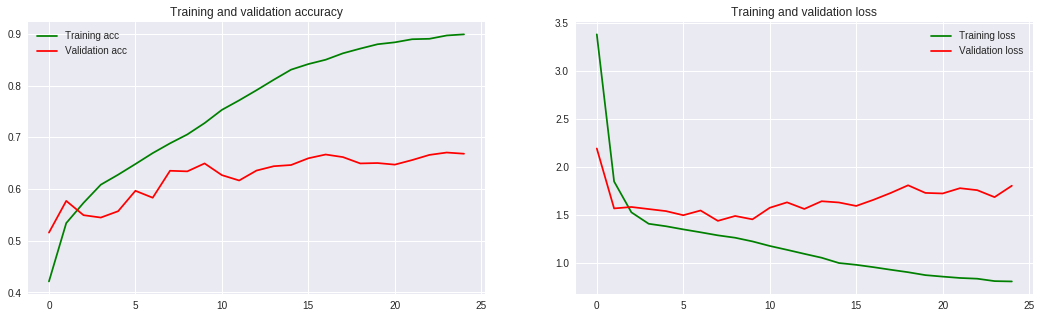

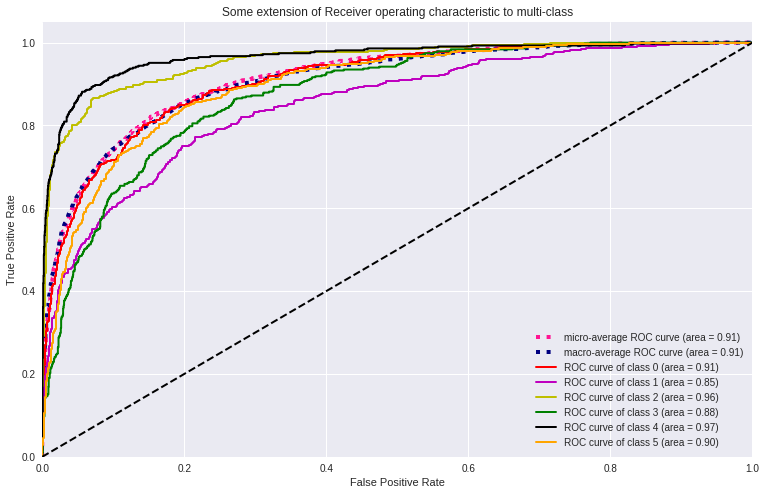

In [0]:
if DEV:
    # conv2d_model.save(prefix + '/conv2d_model.h5')

    print("Avg training: {}".format(model.evaluate(x_train_data, y_train_data)[1]))
    print("Avg validation: {}".format(model.evaluate(x_val_data, y_val_data)[1]))

    y_score = model.predict(x_val_data, batch_size=64)

    # plots train/validation learning curve
    plot_train_vs_validation_acc(model_history)

    # plots a roc curve for each class
    plot_roc_curve(y_test=y_val_data, y_score=y_score)  

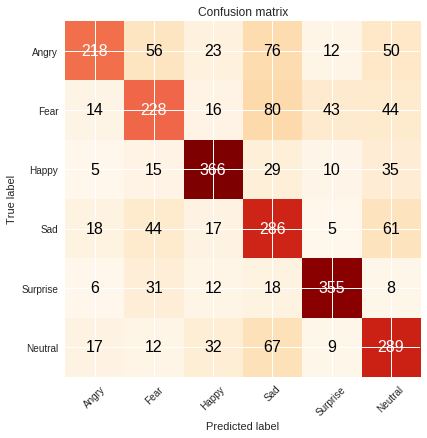

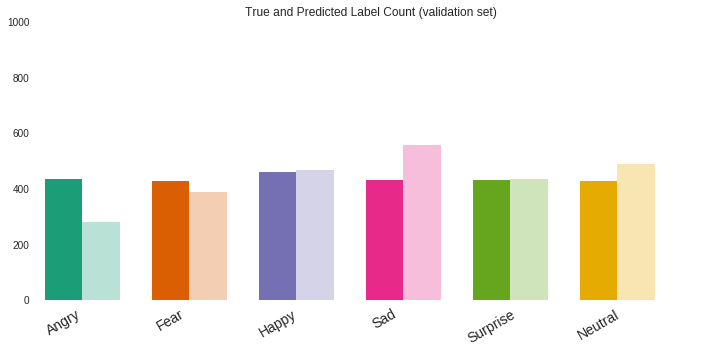

In [0]:
if DEV:
    y_pred = model.predict(x_val_data)
    y_pred = [np.argmax(row) for row in y_pred]
    y_true = [np.argmax(row) for row in y_val_data]

    # plots a confusion matrix
    plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.OrRd)

    plot_distribution_bars(y_true, y_pred, 'True and Predicted Label Count (validation set)')


### Test data evaluation

1800/1800 [==============================] - 1s 490us/step
[2.2708571312162613, 0.5783333333333334]


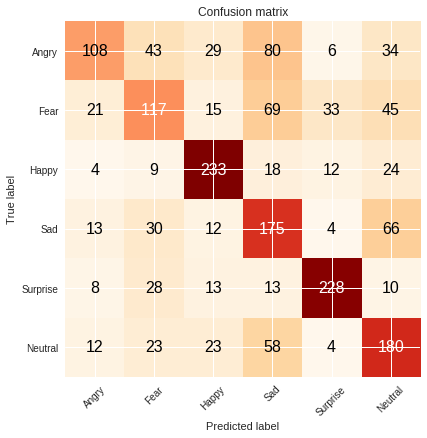

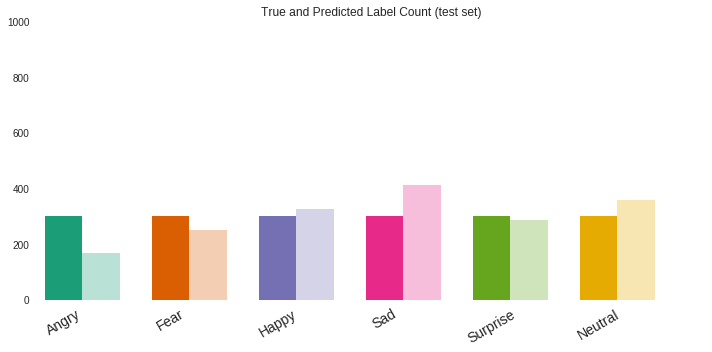

In [0]:
def get_test_data():
    x_test_data = pickle.load( open(os.path.join(PREFIX, "X_test_orig.pickle"), "rb" ) )
    y_test_data = pickle.load( open(os.path.join(PREFIX, "y_test_orig.pickle"), "rb" ) )

    # reshape
    x_test_data = np.array(x_test_data).reshape(-1, 48, 48, 1)
    # normallize
    x_test_data = x_test_data/255.
    y_test_data = np.array(y_test_data)
    # conert the targets to categorical
    y_test_data = to_categorical(y_test_data)

    return x_test_data, y_test_data


if DEV:
    x_test_data, y_test_data = get_test_data()

    # print(best_model_1.evaluate(x_val_data, y_val_data, batch_size=64))
    print(model.evaluate(x_test_data, y_test_data, batch_size=64))

    y_pred_test =  model.predict(x_test_data)
    y_pred_test = [np.argmax(row) for row in y_pred_test]
    y_true_test = [np.argmax(row) for row in y_test_data]

    plot_confusion_matrix(y_true_test, y_pred_test, cmap=plt.cm.OrRd)

    plot_distribution_bars(y_true_test, y_pred_test, 'True and Predicted Label Count (test set)')

In this  case the regularization leads to a decrease in the variance but also reduces the result in the validation set. Maybe these results do not seem very impressive, but we have to bear in mind the difficulty of the task and the limited number of examples we have - even after they are increased to ~`50 000`. I suppose this result is close to the best that can be done in this case.

# Transfer Learning

It is possible to take an advantage from weights that are pre trained for millions examples. It may not give a better result, but we may still try.. In this section I will try some pretrained models like**VGG16** and** ResNet50**. As you can see, the results look promising, but the models need longer training.

## VGG16

In [0]:
!free -h

Adjust the input size:

In [51]:
def duplicate_input_layer(array_input, length, size):
    vg_input = np.empty([length, size, size, 3])
    for index, item in enumerate(vg_input):
        item[:, :, 0] = array_input[index]
        item[:, :, 1] = array_input[index]
        item[:, :, 2] = array_input[index]
    return vg_input

def reshape_for_transfer_learning(X, size):
    tmp = X.reshape(-1,size, size)
    X_3d = duplicate_input_layer(tmp, len(X), size)
    return X_3d

X_train_3d = reshape_for_transfer_learning(X_train_data, INPUT_DIM)
X_val_3d = reshape_for_transfer_learning(X_val_data, INPUT_DIM)

print(X_train_3d.shape)
print(X_val_3d.shape)

(49527, 48, 48, 3)
(2607, 48, 48, 3)


In [52]:
base_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(INPUT_DIM, INPUT_DIM, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
if DEV:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)
    # and a logistic layer
    predictions = Dense(6, activation='softmax')(x)

    # this is the model we will train
    m = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # we chose to train the top 2 inception blocks, i.e. we will freeze
    # the first 19 layers and unfreeze the rest:
    for layer in m.layers[:19]:
        layer.trainable = False

    for layer in m.layers[19:]:
        layer.trainable = True

    m.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # m.summary()

    model_info = m.fit(X_train_3d, y_train_data, 
                       validation_data=(X_val_3d, y_val_data), 
                       epochs=25, 
                       batch_size=64, 
                       verbose=1)

49527/49527 [==============================] - 43s 860us/step
Avg training: 0.6716134633513832
2607/2607 [==============================] - 2s 859us/step
Avg validation: 0.4940544687494447


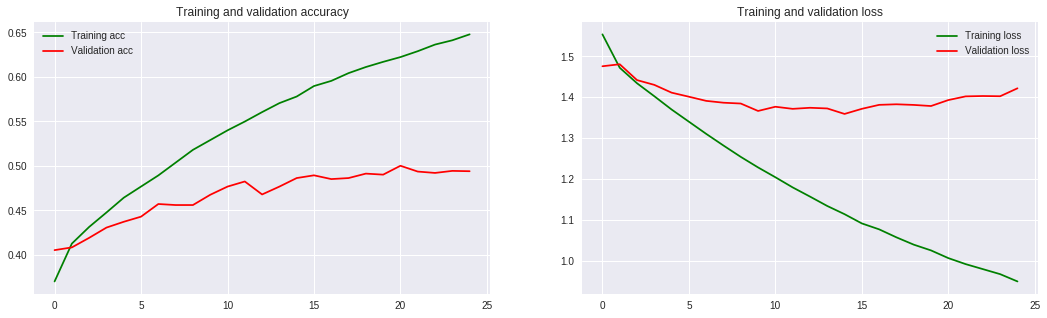

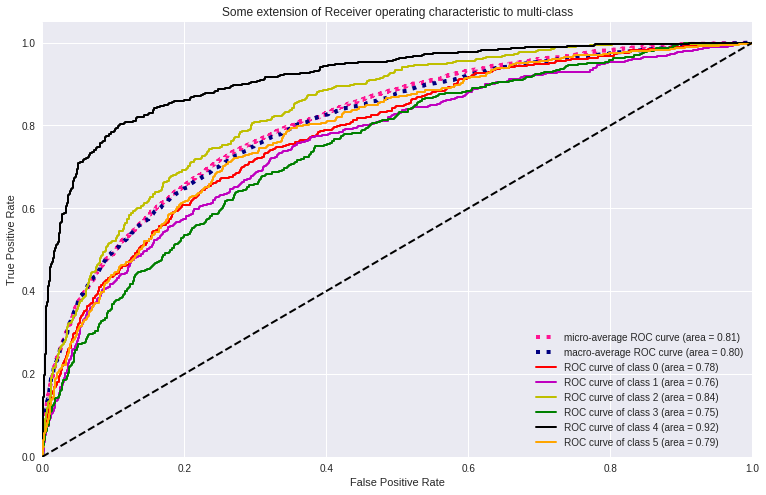

In [68]:
if True:
    print("Avg training: {}".format(m.evaluate(X_train_3d, y_train_data)[1]))
    print("Avg validation: {}".format(m.evaluate(X_val_3d, y_val_data)[1]))

    y_score = m.predict(X_val_3d, batch_size=64)

    # plots train/validation learning curve
    plot_train_vs_validation_acc(model_info)

    # plots a roc curve for each class
    plot_roc_curve(y_test=y_val_data, y_score=y_score) 

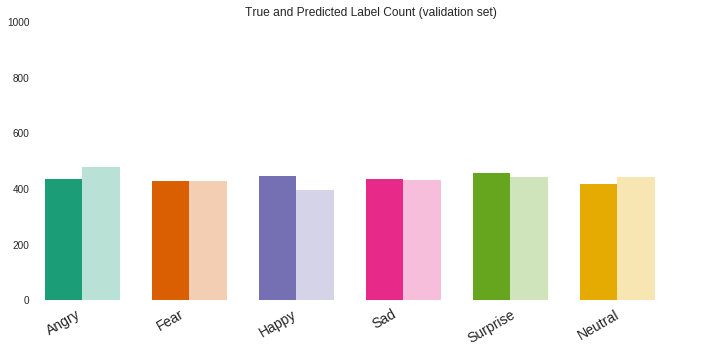

In [77]:
if DEV:
    y_pred = m.predict(X_val_3d)
    y_pred = [np.argmax(row) for row in y_pred]
    y_true = [np.argmax(row) for row in y_val_data]

    plot_distribution_bars(y_true, y_pred, 'True and Predicted Label Count (validation set)')

## ResNet50

In [75]:
base_resNet50_model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(INPUT_DIM, INPUT_DIM, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
# time ~17 minutes
if DEV:
    resnet50_model = Sequential()

    resnet50_model.add(base_resNet50_model)

    resnet50_model.add(Flatten())
    resnet50_model.add(BatchNormalization())

    resnet50_model.add(Dense(2048, activation='relu'))
    resnet50_model.add(BatchNormalization())

    resnet50_model.add(Dense(1024, activation='relu'))
    resnet50_model.add(BatchNormalization())

    resnet50_model.add(Dense(6, activation='softmax'))

    resnet50_model.layers[0].trainable = False

    resnet50_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


    # for index, layer in enumerate(base_resNet50_model.layers):
    #     print(index, layer.name)

    # resnet50_model.summary()


    model_info = resnet50_model.fit(X_train_3d, y_train_data, 
                       validation_data=(X_val_3d, y_val_data), 
                       epochs=15, 
                       batch_size=64, 
                       verbose=1)

49527/49527 [==============================] - 54s 1ms/step
Avg training: 0.9834433743258914
2607/2607 [==============================] - 3s 1ms/step
Avg validation: 0.48868431162916476


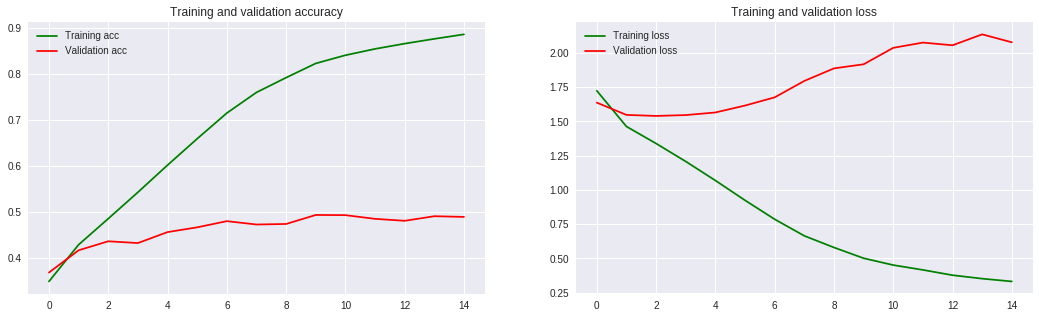

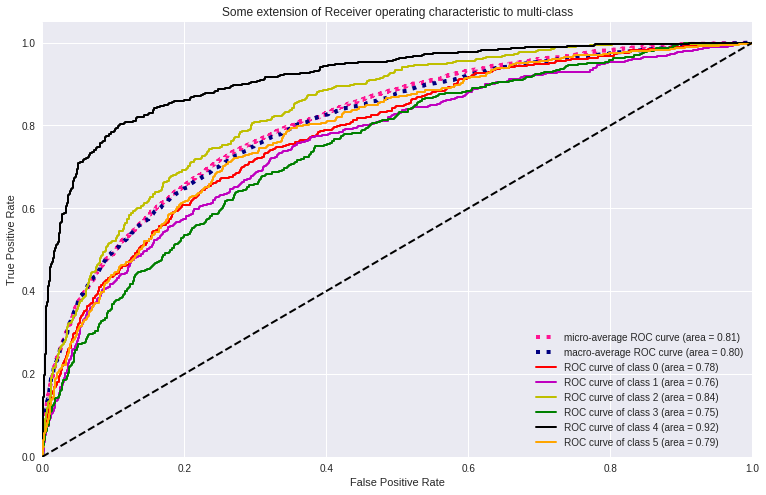

In [80]:
if True:
    print("Avg training: {}".format(resnet50_model.evaluate(X_train_3d, y_train_data)[1]))
    print("Avg validation: {}".format(resnet50_model.evaluate(X_val_3d, y_val_data)[1]))

    y_score = m.predict(X_val_3d, batch_size=64)

    # plots train/validation learning curve
    plot_train_vs_validation_acc(model_info)

    # plots a roc curve for each class
    plot_roc_curve(y_test=y_val_data, y_score=y_score) 

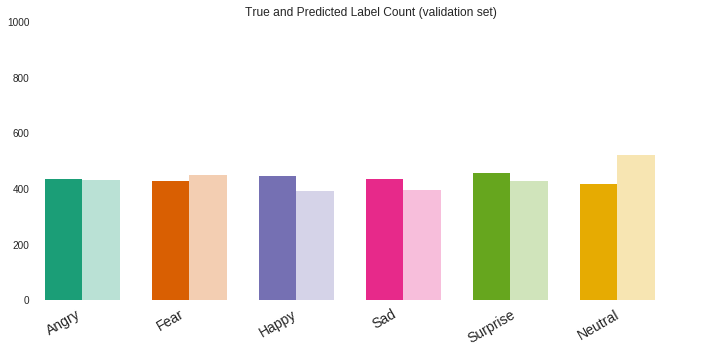

In [81]:
if True:
    y_pred = resnet50_model.predict(X_val_3d)
    y_pred = [np.argmax(row) for row in y_pred]
    y_true = [np.argmax(row) for row in y_val_data]

    plot_distribution_bars(y_true, y_pred, 'True and Predicted Label Count (validation set)')

# Demo

**Please, run [this](#Run-the-selected-Conv2D-model) first to load the model skelethon.** (with `DEV=False`)

For the demo you need a working camera. The faces that the camera sees will be detected with **haar faces**. Press `Q` to escape.

In [0]:
MODEL = model
FACE_CASCADE_PATH = './face.xml'
RESIZE_SHAPE = (48, 48)
MAP = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
model.load_weights(PREFIX + '/best_hyperas_model_prod.h5') # conv2d_model.h5

def predict(model, image):
    input_img = np.array( [image.reshape(INPUT_DIM,INPUT_DIM,1)/255.] )
    y_pred_test = model.predict(input_img)
    predicted = [np.argmax(row) for row in y_pred_test]
    return predicted[0]

def recognize_emotion_from_frame():
    # data:       https://github.com/opencv/opencv/tree/master/data/haarcascades
    # faces, see: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
    face_cascade = cv2.CascadeClassifier(FACE_CASCADE_PATH)
    my_image = None

    cap = cv2.VideoCapture(0)
    is_running = True
    text = ""
    x = y = 0
    
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # looks for faces within the image
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        w = h = 0

        for (x, y, width, height) in faces:
            # display detected emotion
            cv2.putText(frame,text,(x,y), 
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale=1, color=(255,255,255), thickness=2)
            
            # draws a rectangle around the detected face
            cv2.rectangle(frame, (x - w, y - h), (x + width + w, y + height + h), (255, 0, 0), 5)
            face_gray = gray[(y - h): y + height + h, (x - w): x + width + w]
            
            if is_running:
                resized = cv2.resize(face_gray, dsize=RESIZE_SHAPE, interpolation=cv2.INTER_CUBIC)
                try:
                    predicted = predict(MODEL, resized)
                    text = MAP[predicted]
                except Exception as ex:
                    print("Error: {}".format(ex))
                    
            if cv2.waitKey(1) == ord('q'):
                is_running = False 

        cv2.imshow('frame', frame)

        if not is_running:
            break

    cap.release()
    cv2.destroyAllWindows()

recognize_emotion_from_frame()